In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import time
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pickle
from typing import Tuple

warnings.filterwarnings("ignore")
%matplotlib inline


2022-08-29 08:40:09.431879: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def timer(myFunction):
    def functionTimer(*args, **kwargs):
        start_time = time.time()
        result = myFunction(*args, **kwargs)
        end_time = time.time()
        computation_time = round(end_time - start_time, 2)
        print("{} is executed".format(myFunction.__name__), end=" ")
        print('(took: {:.2f} seconds)'.format(computation_time))
        return result
    return functionTimer

In [3]:
@timer
def prepareData(X: "pd.dataFrame", impute_numericals, impute_categories, encode_categories, imputation_type='simple', numcores=6) -> "pd.dataFrame":
    try:
        X.drop(columns=['customer_ID'], inplace=True)
        print("dropped customer_ID.", end=" ")
    except:
        None

    if impute_categories:
        cols = [col for col in X.columns if col[:-6] in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
#        cols=list(X[X[cols].select_dtypes(include=['object']).columns].isna().any().index)
        imp = SimpleImputer(missing_values=np.nan, strategy='constant')
        imp.fit(X[cols])
        X[cols]=imp.transform(X[cols])
        X[cols] = X[cols].astype("str")
        print("imputed categoricals.", end=" ")

    if encode_categories:
        cols = [col for col in X.columns if col[:-6] in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']]
        X[cols] = X[cols].astype("str")
        X[cols] = X[cols].astype("category")
        enc = OrdinalEncoder()
        enc.fit(X[cols])
        X[cols]=enc.transform(X[cols])
        print("encoded categories.", end=" ")
        X[cols] = X[cols].astype("category")

    if impute_numericals:
        cols=list(X.select_dtypes(include=['int64', 'float64']).columns[X.select_dtypes(include=['int64', 'float64']).isna().any()])
        #cols=list(cols - set(X.select_dtypes(include=['int64', 'float64']).columns[X.select_dtypes(include=['int64', 'float64']).notna().all()]))
        params = {
                    'gpu_id' : 0,
                    'tree_method' : 'gpu_hist'
        }

        if imputation_type == 'knn':
            imp = KNNImputer()
        else:
            imp = SimpleImputer(strategy='median')
#        imp.set_params(params)
        X[cols] = imp.fit_transform(X[cols])
        print("imputed numericals.", end=" ")

    return X

@timer
def splitData(X: "pd.dataFrame"):
    y=X['target']
    X.drop(columns=['target'], inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
    print("train/test done.")

#    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1)
#    print("train/validation done.", end=" ")

    return X_train, y_train, X_test, y_test


In [4]:
# Standardise the data sets
@timer
def standardiseNumericalFeats(X_train, X_test):
    """Standardise the numerical features
    
    Returns:
        Standardised X_train and X_test
    """

    scaler = StandardScaler()
    cols=list(X_train.select_dtypes(include=['int64', 'float64']).columns[X.select_dtypes(include=['int64', 'float64']).isna().any()])
    for col in numerical_cols:
        X_train[col] = scaler.fit_transform(X_train[[col]])
        X_test[col] = scaler.transform(X_test[[col]])
        
    return X_train, X_test

In [38]:
def amex_metric(y_pred: pd.DataFrame, y_true: pd.DataFrame)  -> Tuple[str, float]:
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
#        print('tfpc:', (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum())
#        df.to_csv('tfpc'+str(len(df))+'.csv', index=False)
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
#        df.to_csv('wg'+str(len(df))+'.csv', index=False)
#        print('gsum:', df['gini'].sum())
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    yt =pd.DataFrame(y_true.get_label(), columns=['target'])
    yp =pd.DataFrame(y_pred, columns=['prediction'])
    g = normalized_weighted_gini(yt, yp)
    d = top_four_percent_captured(yt, yp)
    print('g:', g, 'd:', d)

    return 'amexmetric', (0.5 * (g+d))

In [5]:
@timer
def trainXgbModel(X_train, y_train, X_test, y_test, FEATS, ROUNDS) -> "XGBoost model obj":    
    params = {
                'eta': 0.02,
                'max_depth': 10,
                'min_child_weight': 7,
                'subsample': 0.6,
                'objective': 'binary:logistic',
#                'objective': 'rank:ndcg',
#                'objective': 'reg:squarederror',
                'eval_metric': ['rmse', 'rmsle', 'auc'],
#                'grow_policy': 'lossguide',
                'gpu_id' : 0,
                'tree_method' : 'gpu_hist',
                'disable_default_eval_metric': 1
        }

    dtrain, dtest = xgb.DMatrix(X_train, y_train, feature_names=FEATS, enable_categorical=True), xgb.DMatrix(X_test, y_test, feature_names=FEATS, enable_categorical=True)

    EVAL_LIST = [(dtrain, "train"),(dtest, "test")]

#    xgb_model = xgb.train(params,dtrain,ROUNDS,EVAL_LIST, early_stopping_rounds = 300, feval=amex_metric)
    xgb_model = xgb.train(params,dtrain,ROUNDS,EVAL_LIST, feval=amex_metric)
    
    return xgb_model

In [6]:
@timer
def trainD1CnnModel(X_train, y_train):
    """Train D1-CNN model
    
    Return:
        keras model obj
    """

    d1_cnn_model = keras.Sequential([
        layers.Dense(4096, activation='relu'),
        layers.Reshape((256, 16)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv1D(filters=16, kernel_size=5, strides=1, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])

    d1_cnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.BinaryCrossentropy()]
    )

    early_stopping = keras.callbacks.EarlyStopping(
        patience=25,
        min_delta=0.001,
        restore_best_weights=True,
    )

    d1_cnn_model.fit(
        X_train, y_train,
        batch_size=10000,
        epochs=5000,
        callbacks=[early_stopping],
        validation_data=(X_test, y_test),
    )
    
    return d1_cnn_model

In [41]:
@timer
def trainTabNetModel(X_train, y_train, pretrainer):
    """Train TabNet model
    
    Args:
        pretrainer: pretrained model. If not using this, use None
        
    Return:
        TabNet model obj
    """
    
    tabNet_model = TabNetClassifier(
                                   n_d=16,
                                   n_a=16,
                                   n_steps=4,
                                   gamma=1.9,
                                   n_independent=4,
                                   n_shared=5,
                                   seed=42,
                                   optimizer_fn = torch.optim.Adam,
                                   scheduler_params = {"milestones": [150,250,300,350,400,450],'gamma':0.2},
                                   scheduler_fn=torch.optim.lr_scheduler.MultiStepLR
                                  )

    tabNet_model.fit(
        X_train = X_train.to_numpy(),
        y_train = y_train.to_numpy(),
        eval_set=[(X_train.to_numpy(), y_train.to_numpy()),
                  (X_test.to_numpy(), y_test.to_numpy())],
        max_epochs = 100,
        batch_size = 256,
        patience = 10,
        from_unsupervised = pretrainer
        )
    
    return tabNet_model

In [42]:
@timer
def tabNetPretrain(X_train):
    """Pretrain TabNet model
    
    Return:
        TabNet pretrainer obj
    """
    tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                             n_independent=2, n_shared=2,
                             seed=42, lambda_sparse=1e-3,
                             optimizer_fn=torch.optim.Adam,
                             optimizer_params=dict(lr=2e-2,
                                                   weight_decay=1e-5
                                                  ),
                             mask_type="entmax",
                             scheduler_params=dict(max_lr=0.05,
                                                   steps_per_epoch=int(X_train.shape[0] / 256),
                                                   epochs=200,
                                                   is_batch_level=True
                                                  ),
                             scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                             verbose=10
                        )

    pretrainer = TabNetPretrainer(**tabnet_params)

    pretrainer.fit(
        X_train=X_train.to_numpy(),
        eval_set=[X_train.to_numpy()],
        max_epochs = 100,
        patience = 10, 
        batch_size = 256, 
        virtual_batch_size = 128,
        num_workers = 1, 
        drop_last = True)
    
    return pretrainer

In [6]:
# Make predictions
@timer
def makePredictions(X_test, xgb_model, d1_cnn_model, tabNet_model):
    """Make predictions
    
    Return:
        Predictions from each models
    """

    y_xgb_pred = None
    y_d1_cnn_pred = None
    y_tabNet_pred = None

    if xgb_model is not None:
        y_xgb_pred = xgb_model.predict(xgb.DMatrix(X_test, enable_categorical=True))
    if d1_cnn_model is not None:
        y_d1_cnn_pred = d1_cnn_model.predict(X_test).reshape(1, -1)[0]
    if tabNet_model is not None:
        y_tabNet_pred = tabNet_model.predict_proba(X_test.to_numpy())[:,1]
    
    return [y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred]

In [7]:
# Evaluation
@timer
def evaluate(y_test, y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred) -> None:
    """Evaluate the predictions
    
    Process:
        Print ROC AUC and F1 score of each models
    """
    preds = {}
    if y_xgb_pred is not None:
        preds['XGBoost'] = y_xgb_pred
    if y_d1_cnn_pred is not None:
        preds['D1 CNN'] = y_d1cnn_pred
    if y_tabNet_pred is not None:
        preds['TabNet'] = y_tabNet_pred
#    preds = {"XGBoost":y_xgb_pred, "D1 CNN":y_d1_cnn_pred, "TabNet":y_tabNet_pred}

#    print(preds)
    for key in preds:
        print("The ROC AUC score of "+ str(key) +" model is " +
              str(round(roc_auc_score(y_test, preds[key]), 4))
             )

    for key in preds:
        print("The F1 score of "+ str(key) +" model at threshold = 0.27 is " +
              str(round(f1_score(y_test, np.where(preds[key] > 0.27, 1, 0)), 4))
             )

In [8]:
# Plot prediction distribution
def plotPredictionDistribution(y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred) -> None:
    """Plot histogram of predicted probability distributions of each model
    """

    preds = {}
    if y_xgb_pred is not None:
        preds['XGBoost'] = y_xgb_pred
    if y_d1_cnn_pred is not None:
        preds['D1 CNN'] = y_d1cnn_pred
    if y_tabNet_pred is not None:
        preds['TabNet'] = y_tabNet_pred
#    preds = {"XGBoost":y_xgb_pred, "D1 CNN":y_d1_cnn_pred, "TabNet":y_tabNet_pred}

    for key in preds:
        plt.hist(preds[key], bins = 100)
        plt.title(f"Predicted probability distribution of {key}")
        plt.show()

In [9]:
@timer
def readData(tag, frange, fstart=0):
    traindf=pd.DataFrame()
    for i in range(fstart, frange):
        print("x" + tag + str(i), end=" ")
        traindf = pd.concat([traindf, pd.read_csv("x" + tag + str(i) + "dtcnt.csv")], ignore_index=True)

    [traindf[col].astype('category') for col in traindf.columns if (col[:len(col)-6] in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']) or ('yearmonth' in col) or ('day_of_week' in col)]
    #    traindf[col] = traindf[col].astype('category')
    #print("updated categories...")

    return traindf

In [10]:
@timer
def balancedata(X_train: "pd.dataFrame", y_train: "pd.dataFrame") -> ("pd.dataFrame", "pd.dataFrame"):
    sm = SMOTE(random_state = 2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    print("The ratio of target class in training set is " + str(round(y_train_res.sum()/len(y_train_res) * 100, 2)) + "%")
    print("Len of X_train is", len(X_train), " & X_train_res is", len(X_train_res))
    return X_train_res, y_train_res


In [54]:
#Load and split the data

ROUNDS = 51
loads=[False, True, True, True] # [csv, xgb, d1cnn, tabnet]
nof, fstart=12, 0
fprefix="" #str(nof)
ftag = "".join([str(i) for i in range(nof)])
ftag="all"

if loads[0]:
    print("Loading the data", "X" + fprefix + ftag + "bal.csv", end=" ")
    X = pd.read_csv("X" + fprefix + ftag + "bal.csv")
else:
    print("Reading the data", end=" ")
    df = readData(fprefix, nof, fstart)
    print("Preprocessing the data", end=" ")
    X=prepareData(df.loc[:, ~df.isnull().all()], True, True, True)
    X.to_csv("X" + fprefix + ftag + ".csv", index=False)
    y=X['target']
    X_train_res, y_train_res = balancedata(X, y)
    if 'target' not in X.columns:
        X=pd.concat([X_train_res, pd.DataFrame(y_train_res, columns=["target"])], axis='columns')
    else:
        X= X_train_res
    X.to_csv("X" + fprefix + ftag + "bal.csv", index=False)

print("")
y=X['target']

FEATS = [col for col in X.columns if (col[:len(col)-6] in ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']) or ('yearmonth' in col) or ('day_of_week' in col) or ('day_of_month') in col or ('day_of_year' in col)]

X_train, y_train, X_test, y_test = splitData(X)

print("The ratio of target class in training set is " + str(round(y_train.sum()/len(y_train) * 100, 2)) + "%")
print("The ratio of target class in test set is " + str(round(y_test.sum()/len(y_test) * 100, 2)) + "%")

Reading the data x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 readData is executed (took: 22.55 seconds)
Preprocessing the data dropped customer_ID. imputed categoricals. encoded categories. imputed numericals. prepareData is executed (took: 761.22 seconds)
The ratio of target class in training set is 50.0%
Len of X_train is 63283  & X_train_res is 72496
balancedata is executed (took: 435.50 seconds)

train/test done.
splitData is executed (took: 3.36 seconds)
The ratio of target class in training set is 49.98%
The ratio of target class in test set is 50.18%


In [55]:
torch.cuda.empty_cache() # PyTorch thing

loads=[True, True, True, False] # [csv, xgb, d1cnn, tabnet]
#nof=9
ftag = "".join([str(i) for i in range(nof)])
tag='xgb'
ROUNDS=1200

if loads[1]:
    print("Loading XGBoost model")
#    xgb_model = pickle.load(open(tag+"X" + ftag + "model", "rb"))
else:
    print("Training XGBoost model")
    xgb_model = trainXgbModel(X_train, y_train, X_test, y_test, X_train.columns, ROUNDS)
#    pickle.dump(xgb_model, open(tag+"X" + ftag + "model", "wb"))
    pickle.dump(xgb_model, open(tag+"X" + str(nof) + "model", "wb"))

'''tag='d1cnn'
if loads[2]:
    print("Loading MLP model")
    d1_cnn_model = keras.models.load_model(tag+"X" + ftag + "model")
else:
    print("Training MLP model")
    d1_cnn_model = trainD1CnnModel(X_train, y_train)
    d1_cnn_model.save(tag+"X" + ftag + "model")
'''
d1_cnn_model=None

tag='tabnet'
if loads[3]:
    print("Loading TabNet model")
    tabNet_model = TabNetClassifier()
    tabNet_model.load_model(tag+"X" + ftag + "model.zip")
else:
    print("Training TabNet model")
#    tabNet_model = trainTabNetModel(X_train, y_train, None)
    tabNet_model = trainTabNetModel(X_train_res, y_train_res, tabNetPretrain(X_train))
    tabNet_model.save_model(tag+"X" + ftag + "model")

#tabNet_model=None

Loading XGBoost model
Training TabNet model
Device used : cuda


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Making predictions
makePredictions is executed (took: 4.23 seconds)
Evaluation of the model
The ROC AUC score of XGBoost model is 0.9996
The F1 score of XGBoost model at threshold = 0.27 is 0.9675
evaluate is executed (took: 0.04 seconds)
Prediction distribution


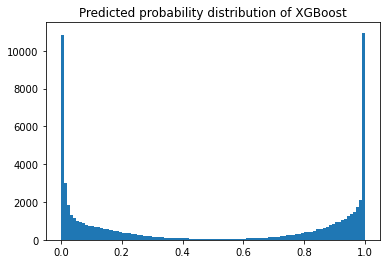

Making predictions
makePredictions is executed (took: 0.40 seconds)
Evaluation of the model
The ROC AUC score of XGBoost model is 0.9401
The F1 score of XGBoost model at threshold = 0.27 is 0.8495
evaluate is executed (took: 0.01 seconds)
Prediction distribution


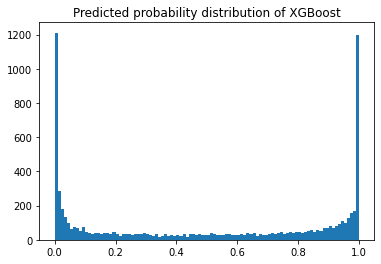

In [15]:
###Train Predicitons
print("Making predictions")
y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred = makePredictions(X_train, xgb_model, d1_cnn_model, tabNet_model)

print("Evaluation of the model")
evaluate(y_train, y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred)

print("Prediction distribution")
plotPredictionDistribution(y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred)


###Test Predictions
print("Making predictions")
y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred = makePredictions(X_test, xgb_model, d1_cnn_model, tabNet_model)

print("Evaluation of the model")
evaluate(y_test, y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred)

print("Prediction distribution")
plotPredictionDistribution(y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred)


In [16]:
mdf = pd.read_csv("mdf13dts.csv")
#mdf = pd.read_csv("mdfdtcnt.csv")
testdf = pd.DataFrame()
for i in range(12):
    print("t" + str(i), end=" ")
    testdf = pd.concat([testdf, pd.read_csv("t" + str(i) + "13dts.csv")], ignore_index=True)
#    testdf = pd.concat([testdf, mdf], ignore_index=True)
#    testdf.drop(testdf[testdf.customer_ID == 'spc'].index, inplace=True)
    #print(testdf.columns)
cust = testdf[['customer_ID']]
testdf.drop(columns=['origmissrcnt', 'totmissrcnt'], inplace=True)
#testdf.drop(columns=['D_87201806', 'D_88201806', 'D_88201805', 'D_87201807'], inplace=True)
Xtest=prepareData(testdf, False, False, True)
print("Making predictions...", end=" ")
y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred = makePredictions(Xtest[X.columns], xgb_model, None, None)
pd.concat([cust, pd.DataFrame(y_xgb_pred, columns=["Label"])], axis='columns').to_csv("test/t" + "01234567891011" + ".preds", index=False)
print("saved predictions.")


t0 t1 t2 t3 t4 t5 t6 t7 t8 t9 t10 t11 dropped customer_ID. encoded categories. prepareData is executed (took: 132.01 seconds)
Making predictions... makePredictions is executed (took: 94.33 seconds)
saved predictions.


In [14]:
for i in range(41):
    print("t12-" + str(i) + "dtcnt.csv", end=" ")
    testdf = pd.read_csv("t12-" + str(i) + "dtcnt.csv")
    cust = testdf[['customer_ID']]
    testdf.drop(columns=['origmissrcnt', 'totmissrcnt'], inplace=True)
    X=prepareData(testdf, False, False, True)
    print("Making predictions...", end=" ")
    y_xgb_pred, y_d1_cnn_pred, y_tabNet_pred = makePredictions(X, xgb_model, None, None)
    pd.concat([cust, pd.DataFrame(y_xgb_pred, columns=["Label"])], axis='columns').to_csv("test/t12-" + str(i) + ".preds", index=False)
    print("saved predictions.")


t12-0dtcnt.csv dropped customer_ID. encoded categories. prepareData is executed (took: 12.45 seconds)
Making predictions... makePredictions is executed (took: 77.69 seconds)
saved predictions.
t12-1dtcnt.csv dropped customer_ID. encoded categories. prepareData is executed (took: 12.92 seconds)
Making predictions... makePredictions is executed (took: 78.13 seconds)
saved predictions.
t12-2dtcnt.csv dropped customer_ID. encoded categories. prepareData is executed (took: 12.82 seconds)
Making predictions... makePredictions is executed (took: 75.14 seconds)
saved predictions.
t12-3dtcnt.csv dropped customer_ID. encoded categories. prepareData is executed (took: 12.94 seconds)
Making predictions... makePredictions is executed (took: 80.32 seconds)
saved predictions.
t12-4dtcnt.csv dropped customer_ID. encoded categories. prepareData is executed (took: 13.13 seconds)
Making predictions... makePredictions is executed (took: 78.64 seconds)
saved predictions.
t12-5dtcnt.csv dropped customer_ID.

In [15]:
preds=pd.DataFrame()
cutoff=0.5
for i in range(41):
    preds = pd.concat([preds, pd.read_csv("test/t12-" + str(i) + ".preds")])
    print(i, round(1-cutoff, 1), preds[round(preds['Label'],1) < round((1-cutoff),1) ]['Label'].count(), round(cutoff, 1), preds[round(preds['Label'], 1) > round(cutoff,1)]['Label'].count(), (preds[round(preds['Label'],1) > round(cutoff, 1)]['Label'].count() / preds['Label'].count()))
print("")
cutoff=0.9
for i in range(5):
    print(round(1-cutoff, 1), preds[round(preds['Label'],1) < round((1-cutoff),1) ]['Label'].count(), round(cutoff, 1), preds[round(preds['Label'], 1) > round(cutoff,1)]['Label'].count(), (preds[round(preds['Label'],1) > round(cutoff, 1)]['Label'].count() / preds['Label'].count()))
    cutoff-=0.1


0 0.5 14089 0.5 5345 0.26676981433419844
1 0.5 28000 0.5 10855 0.2709347310620242
2 0.5 42058 0.5 16256 0.27050953506173664
3 0.5 56041 0.5 21706 0.27089495426011206
4 0.5 70063 0.5 27101 0.27057977815273715
5 0.5 84064 0.5 32525 0.27062220225317424
6 0.5 97942 0.5 38091 0.2716594397215724
7 0.5 111974 0.5 43463 0.2712250463347208
8 0.5 125927 0.5 48917 0.27134504870309967
9 0.5 139947 0.5 54333 0.2712405086040347
10 0.5 153928 0.5 59773 0.2712712848999746
11 0.5 167897 0.5 65228 0.2713559477156811
12 0.5 182059 0.5 70492 0.27070140742305254
13 0.5 195905 0.5 76102 0.2713664241905577
14 0.5 209937 0.5 81506 0.27126169001897027
15 0.5 223924 0.5 86970 0.2713513277401118
16 0.5 237950 0.5 92370 0.27124965128400896
17 0.5 251892 0.5 97859 0.27140309567985976
18 0.5 265855 0.5 103272 0.2713421282879266
19 0.5 279799 0.5 108702 0.2713310452418097
20 0.5 293843 0.5 114098 0.2712401908461368
21 0.5 307894 0.5 119485 0.27113286497476674
22 0.5 321986 0.5 124831 0.2709523520116689
23 0.5 335951

In [35]:
root="/home/paperspace/amex-default-prediction/"

samples = pd.read_csv(root + "sample_submission.csv")

preddf= pd.DataFrame()
rangemin, rangemax = 0, 1

preds = pd.read_csv(root+"/test/t"+ "01234567891011" + ".preds")
print(preds['Label'].min(), preds['Label'].max())
preds['Label'] = ( (preds[['Label']] - rangemin) / (rangemax - rangemin) ) * (0.96 - 0) + 0
print(preds['Label'].min(), preds['Label'].max())
preddf = pd.concat([preddf, preds], ignore_index=True, axis=0)

for i in range(0):
#    preds = pd.read_csv(root+"/test/x"+ str(i) + "13dtsnew.preds")
#    rangemin = preds['Label'].min()
#    rangemax = preds['Label'].max()
#    rangemin = min(preds['Label'].min(), rangemin)
#    rangemax = max(preds['Label'].max(), rangemax)
    preds = pd.read_csv(root+"/test/t"+ str(i) + ".preds")
#    rangemin = min(preds['Label'].min(), rangemin)
#    rangemax = max(preds['Label'].max(), rangemax)
#    preds['Label'] = ( (preds[['Label']] - rangemin) / (rangemax - rangemin) ) * (1 - 0) + 0
    print(i, preds['Label'].min(), preds['Label'].max(), "actual:", rangemin, rangemax, "1:", preds[(round(preds['Label']) == 1)].count()[0], "0:", preds[(round(preds['Label']) == 0)].count()[0])
    cutoff=0.9
    for j in range(5):
        print(i, round(1-cutoff, 1), preds[round(preds['Label'],1) < round((1-cutoff),1) ]['Label'].count(), round(cutoff, 1), preds[round(preds['Label'], 1) > round(cutoff,1)]['Label'].count(), (preds[round(preds['Label'],1) > round(cutoff, 1)]['Label'].count() / preds['Label'].count()))
        cutoff-=0.1
    preddf = pd.concat([preddf, preds], ignore_index=True, axis=0)
print("")
for i in range(41):
    preds = pd.read_csv(root+"/test/t12-"+ str(i) + ".preds") #.rename(columns={"prediction":"Label"}).drop(columns="Unnamed: 0")
    if (preds['Label'].agg(['min', 'max'])[0] < 0) or (preds['Label'].agg(['min', 'max'])[1]>1):
        print(i, preds['Label'].agg(['min', 'max'])[0], preds['Label'].agg(['min', 'max'])[1])
        rangemin = min(preds['Label'].min(), rangemin)
        rangemax = max(preds['Label'].max(), rangemax)
        preds['Label'] = ( (preds[['Label']] - rangemin) / (rangemax - rangemin) ) * (1 - 0) + 0
    preddf = pd.concat([preddf, preds], ignore_index=True, axis=0)

print("preds min max:", (preddf['Label'].min(), preddf['Label'].max()))

0.00024152208 0.99981505
0.00023186119679999997 0.959822448

preds min max: (0.00023186119679999997, 0.99993396)


In [36]:
valids = pd.merge(samples, preddf, on='customer_ID', how='inner')
valids.rename(columns={'prediction': 'target'}, inplace=True)
valids.rename(columns={'Label': 'prediction'}, inplace=True)

valids['prediction'].fillna(0, inplace=True)

print("matching 1's", valids[(valids['target'] == round(valids['prediction'])) & (valids['target'] == 1)].count()[0], valids[(valids['target'] == 1)].count()[0])
print("matching 0's", valids[(valids['target'] == round(valids['prediction'])) & (valids['target'] == 0)].count()[0], valids[(valids['target'] == 0)].count()[0])
print("matching", valids[valids['target'] == round(valids['prediction'])].count()[0], "total", valids.count()[0], "%", valids[valids['target'] == round(valids['prediction'])].count()[0]/valids.count()[0])

matching 1's 0 0
matching 0's 641095 924621
matching 641095 total 924621 % 0.6933597657851163


In [37]:
valids[['customer_ID', 'prediction']].to_csv('submission.csv', index=False)


In [ ]:
len(valids['customer_ID'].unique())